In [1]:
import numpy as np
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from keras.models import Sequential
from keras import models, layers, activations
from keras.layers import Conv2D, TimeDistributed, BatchNormalization, MaxPooling2D, Flatten, Bidirectional, Dense, Dropout, Embedding
from keras.callbacks import EarlyStopping

In [2]:
x_data = np.load('lip/lip_x_data.npy') # x_save.npy
y_data = np.load('lip/lip_y_data.npy') # y_data.npy
y_data = keras.utils.to_categorical(y_data,11)
print(x_data.shape, y_data.shape)

(3000, 27, 64, 64, 3) (3000, 11)


In [4]:
# Train과 Test 분리
X_train, X_test, Y_train, Y_test = train_test_split(x_data, y_data, test_size = 0.2, shuffle = True, stratify=y_data)
#X_train = X_train / 255
print("X_train: {}, X_test: {}".format(X_train.shape, X_test.shape))
print("Y_train: {}, Y_test: {}".format(Y_train.shape, Y_test.shape))

X_train: (2400, 27, 64, 64, 3), X_test: (600, 27, 64, 64, 3)
Y_train: (2400, 11), Y_test: (600, 11)


In [5]:
from tensorflow.keras.applications import Xception

class Xception_LSTM(keras.Model):
    def __init__(self, num_classes):
        super(Xception_LSTM, self).__init__()
        #self.BZ = input_shape[0]
        #self.frame = input_shape[1]
        self.xc = TimeDistributed(Xception(weights='imagenet', include_top=False,
                                               pooling='max'))
        self.xc.trainable = False
        self.bilstm = layers.Bidirectional(layers.LSTM(128), merge_mode='concat')
        self.dense2 = layers.Dense(128, activation='relu')
        self.dense = layers.Dense(num_classes, activation='softmax')
        self.max_pool = TimeDistributed(MaxPooling2D(pool_size=(2, 2)))
        self.dropout2 = layers.Dropout(0.2)
        self.dropout3 = layers.Dropout(0.3)
        self.flat = TimeDistributed(Flatten())

    def call(self, x):
        x = self.xc(x)
        x = self.flat(x)
        x = self.dropout2(x)
        x = self.bilstm(x)
        #x = self.dense2(x)
        x = self.dropout2(x)
        return self.dense(x)

In [6]:
def get_model_vgg():
    return Xception_LSTM(num_classes = 11)

In [7]:
model = get_model_vgg()
model.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])

83689472/83683744 [==============================] - 8s 0us/step


In [8]:
es = EarlyStopping(monitor = 'val_loss', patience = 10)
history = model.fit(X_train, Y_train, batch_size=32, epochs=100, verbose = 1, validation_split=0.2, callbacks = [es])

Epoch 1/100
60/60 [==============================] - 852s 14s/step - loss: 2.3496 - accuracy: 0.1189 - val_loss: 2.2489 - val_accuracy: 0.1750
Epoch 2/100
60/60 [==============================] - 784s 13s/step - loss: 2.1313 - accuracy: 0.2305 - val_loss: 2.1324 - val_accuracy: 0.2229
Epoch 3/100
60/60 [==============================] - 775s 13s/step - loss: 1.9145 - accuracy: 0.3155 - val_loss: 1.8972 - val_accuracy: 0.3063
Epoch 4/100
60/60 [==============================] - 774s 13s/step - loss: 1.5553 - accuracy: 0.4485 - val_loss: 1.6716 - val_accuracy: 0.3708
Epoch 5/100
60/60 [==============================] - 773s 13s/step - loss: 1.2798 - accuracy: 0.5732 - val_loss: 1.5983 - val_accuracy: 0.4333
Epoch 6/100
60/60 [==============================] - 772s 13s/step - loss: 0.9684 - accuracy: 0.6789 - val_loss: 1.5414 - val_accuracy: 0.4583
Epoch 7/100
60/60 [==============================] - 774s 13s/step - loss: 0.8086 - accuracy: 0.7279 - val_loss: 1.4543 - val_accuracy: 0.5208

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


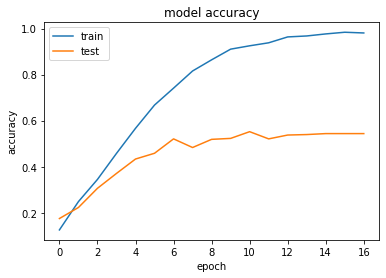

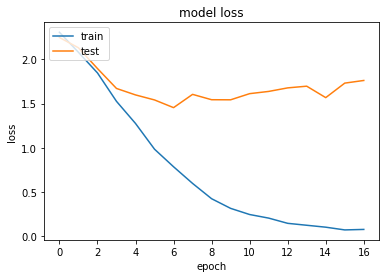

In [9]:

import matplotlib.pyplot as plt
# list all data in history
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()